# Brialle Detection - Image Processing


### Work-Flow 


The Following steps are explained in detail in `Coding and Explaination` Section.


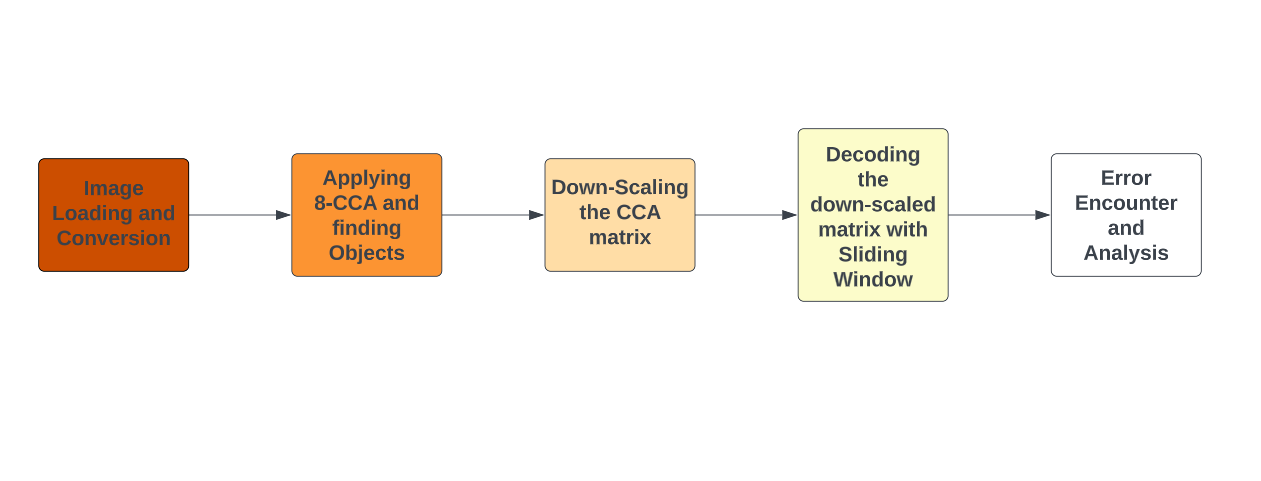

### Coding and Explaination

In [ ]:
# Mounting Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Downloading the Dependencies
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

#### Image Loading and Conversion to Binary.
* RGB Image is Converted to Gray-Scale
* Thresholding is applied on Gray-Scale to get a Binary output Image

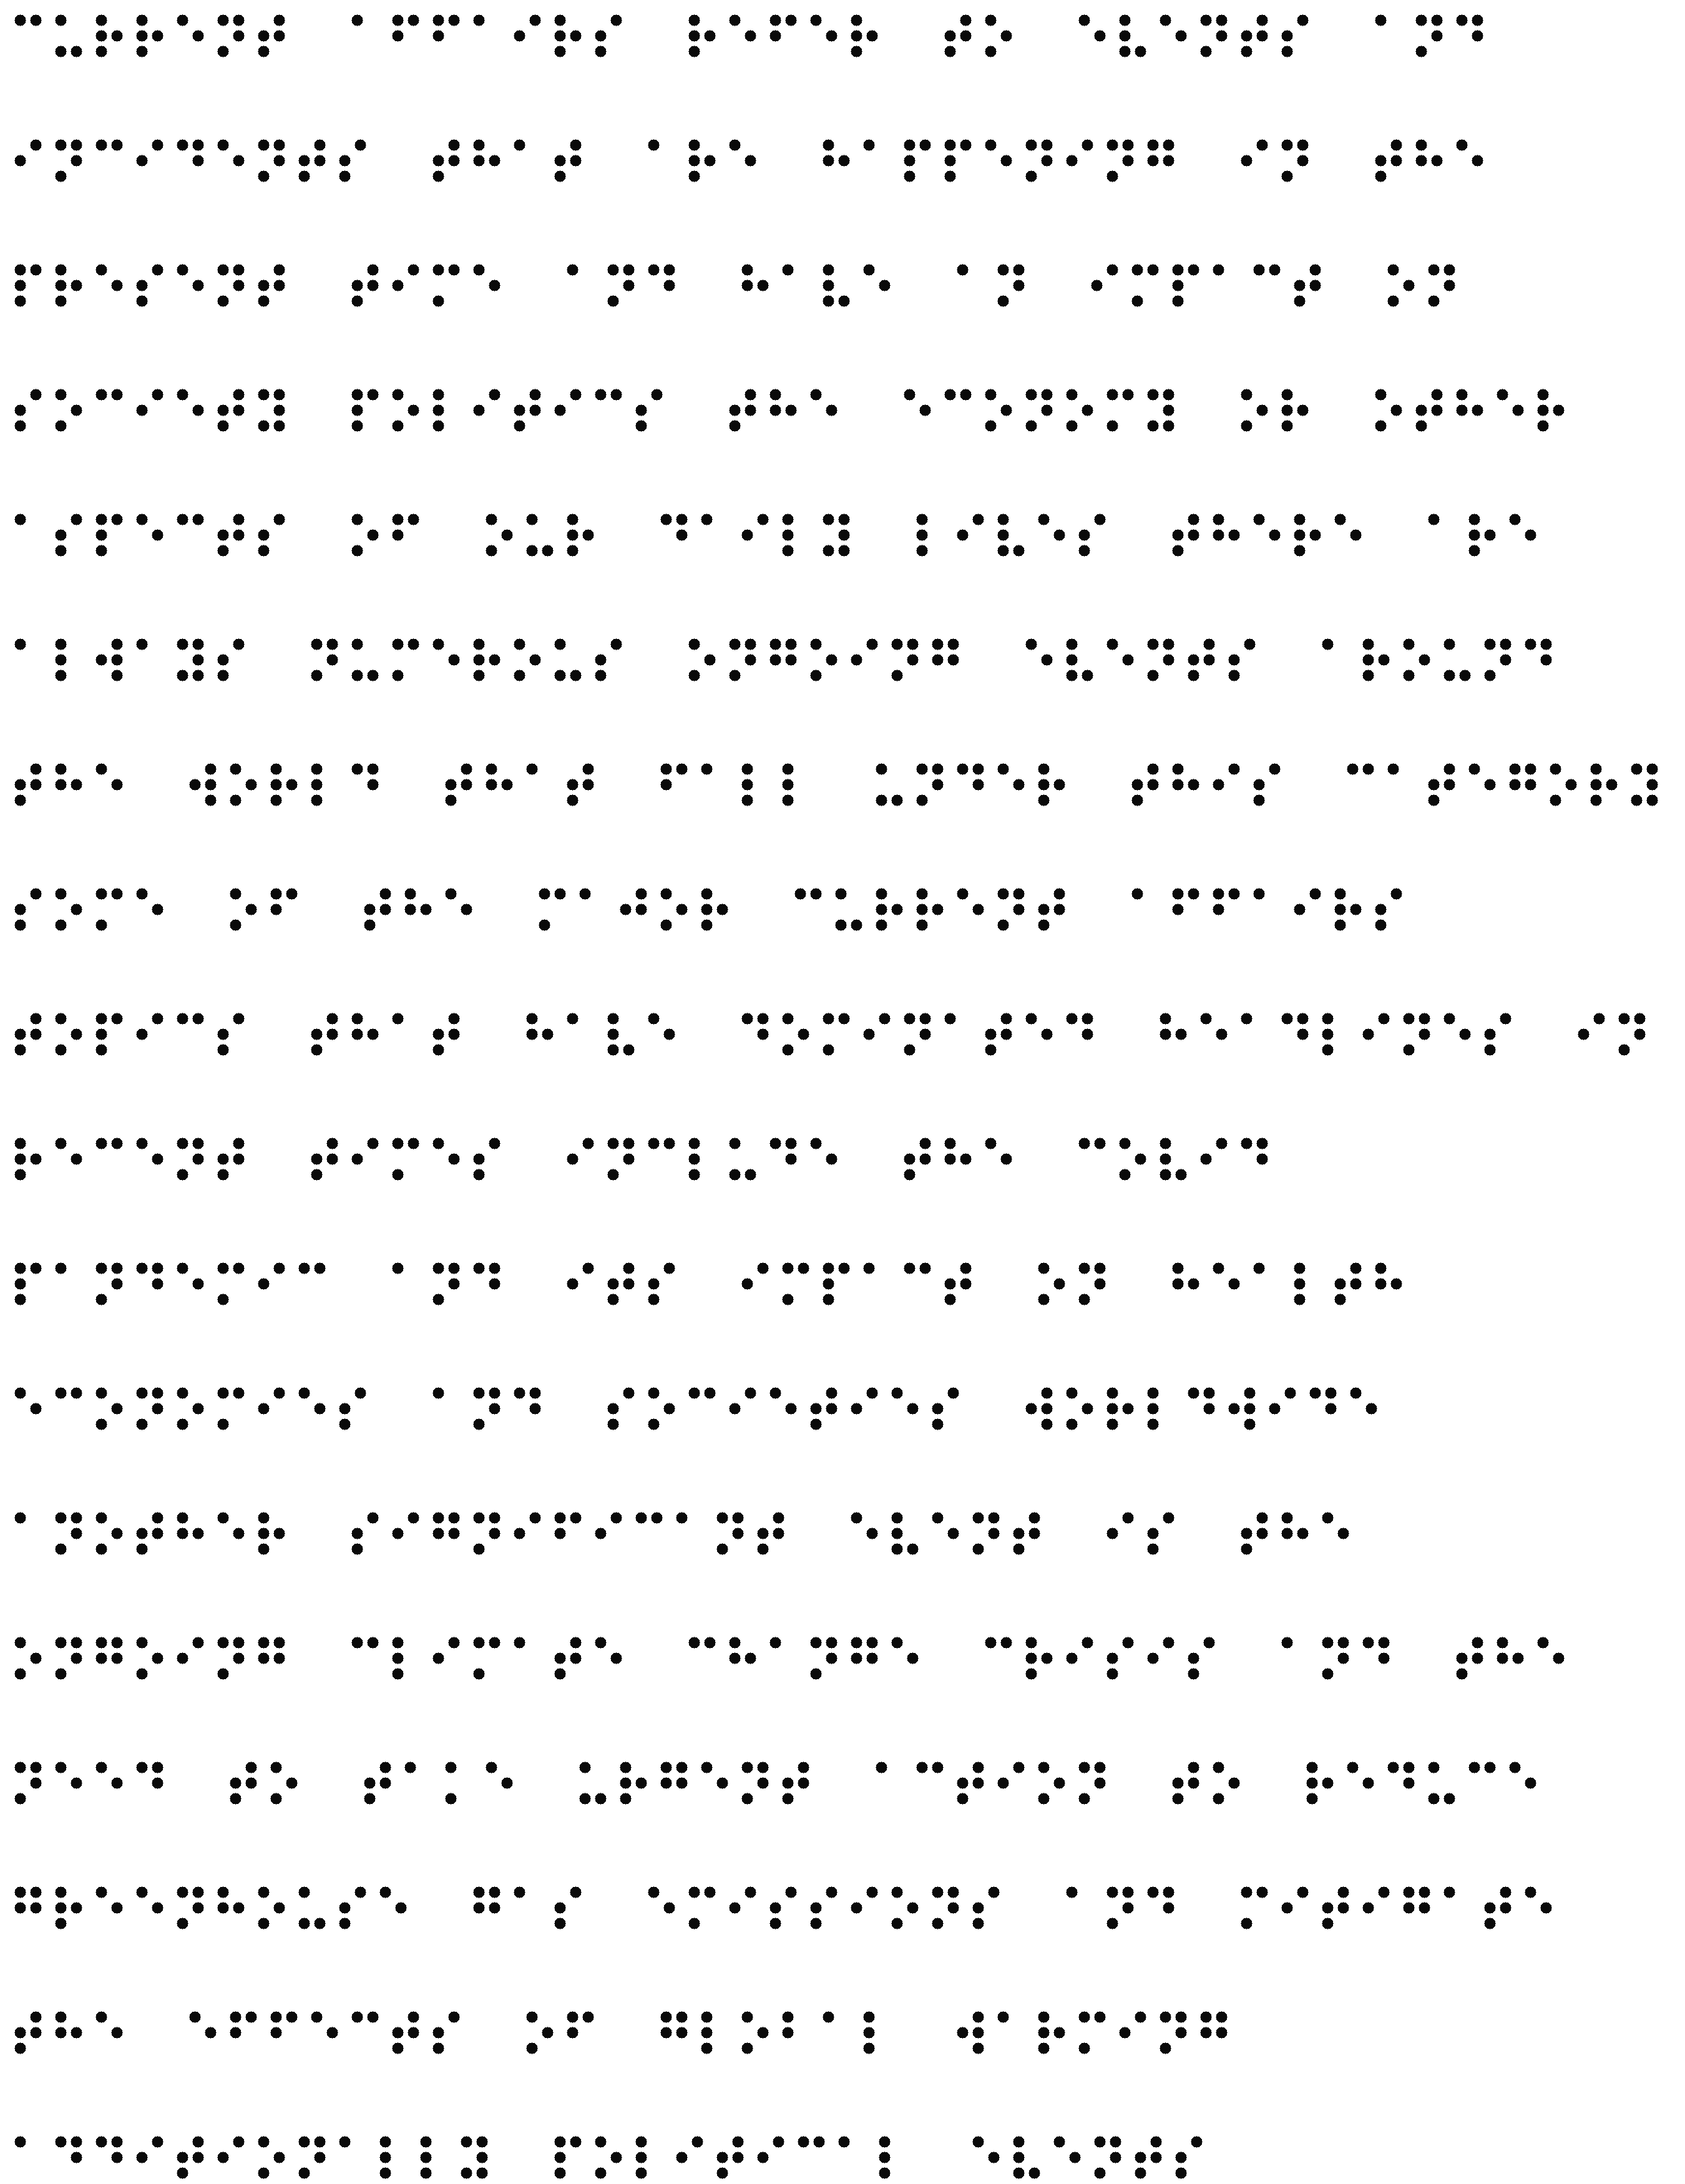

In [ ]:
image_matrix = cv2.imread("/content/drive/MyDrive/Assignment-1/Braille.png")
cv2_imshow(image_matrix)

In [ ]:
# Analyzing Matrix Shape
image_matrix.shape

(3500, 2700, 3)

In [ ]:
# Convert RGB image to Gray scale image
gray_matrix = cv2.cvtColor(image_matrix, cv2.COLOR_BGR2GRAY)
gray_matrix.shape

(3500, 2700)

In [ ]:
# apply thresholding to convert grayscale to binary image
ret,thresh = cv2.threshold(gray_matrix,70,255,0) # np.min(gray_matrix) could be used instead of 70 to generalize it well

In [ ]:
thresh

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

#### Finding the Objects in the Image
* 8 Connected Components Analysis is used to classify the Objects in the Image

In [ ]:
# Making an 8-Connected Component Matrix to classify objects in above image
def create_connected_matrix(matrix):
  label = 0
  connected_matrix = np.zeros(matrix.shape, dtype=int)
  row, col = matrix.shape

  threshold_matrix = (matrix < 1).astype(int)
  equivalency_list = {}

  for i in range(row):
    for j in range(col):
      if threshold_matrix[i][j] == 1:
        neighbors = []
        if j > 0 and threshold_matrix[i][j-1] != 0:
          neighbors.append(connected_matrix[i][j-1])
        if i > 0 and j > 0 and threshold_matrix[i-1][j-1] != 0:
          neighbors.append(connected_matrix[i-1][j-1])
        if i > 0 and threshold_matrix[i-1][j] != 0:
          neighbors.append(connected_matrix[i-1][j])
        if i > 0 and j < col-1 and threshold_matrix[i-1][j+1] != 0:
          neighbors.append(connected_matrix[i-1][j+1])

        if not neighbors:
          label += 1
          connected_matrix[i][j] = label
        else:
          neighbors = sorted(set(neighbors))
          connected_matrix[i][j] = neighbors[0]
          for neighbor in neighbors[1:]:
            equivalency_list[neighbor] = neighbors[0]

  # update equivalency classes
  for i in range(row):
    for j in range(col):
      if connected_matrix[i][j] in equivalency_list:
        connected_matrix[i][j] = equivalency_list[connected_matrix[i][j]]

  num_objects = len(np.unique(connected_matrix)) - 1  
  return connected_matrix, num_objects

In [ ]:
connected_matrix, label = create_connected_matrix(thresh)

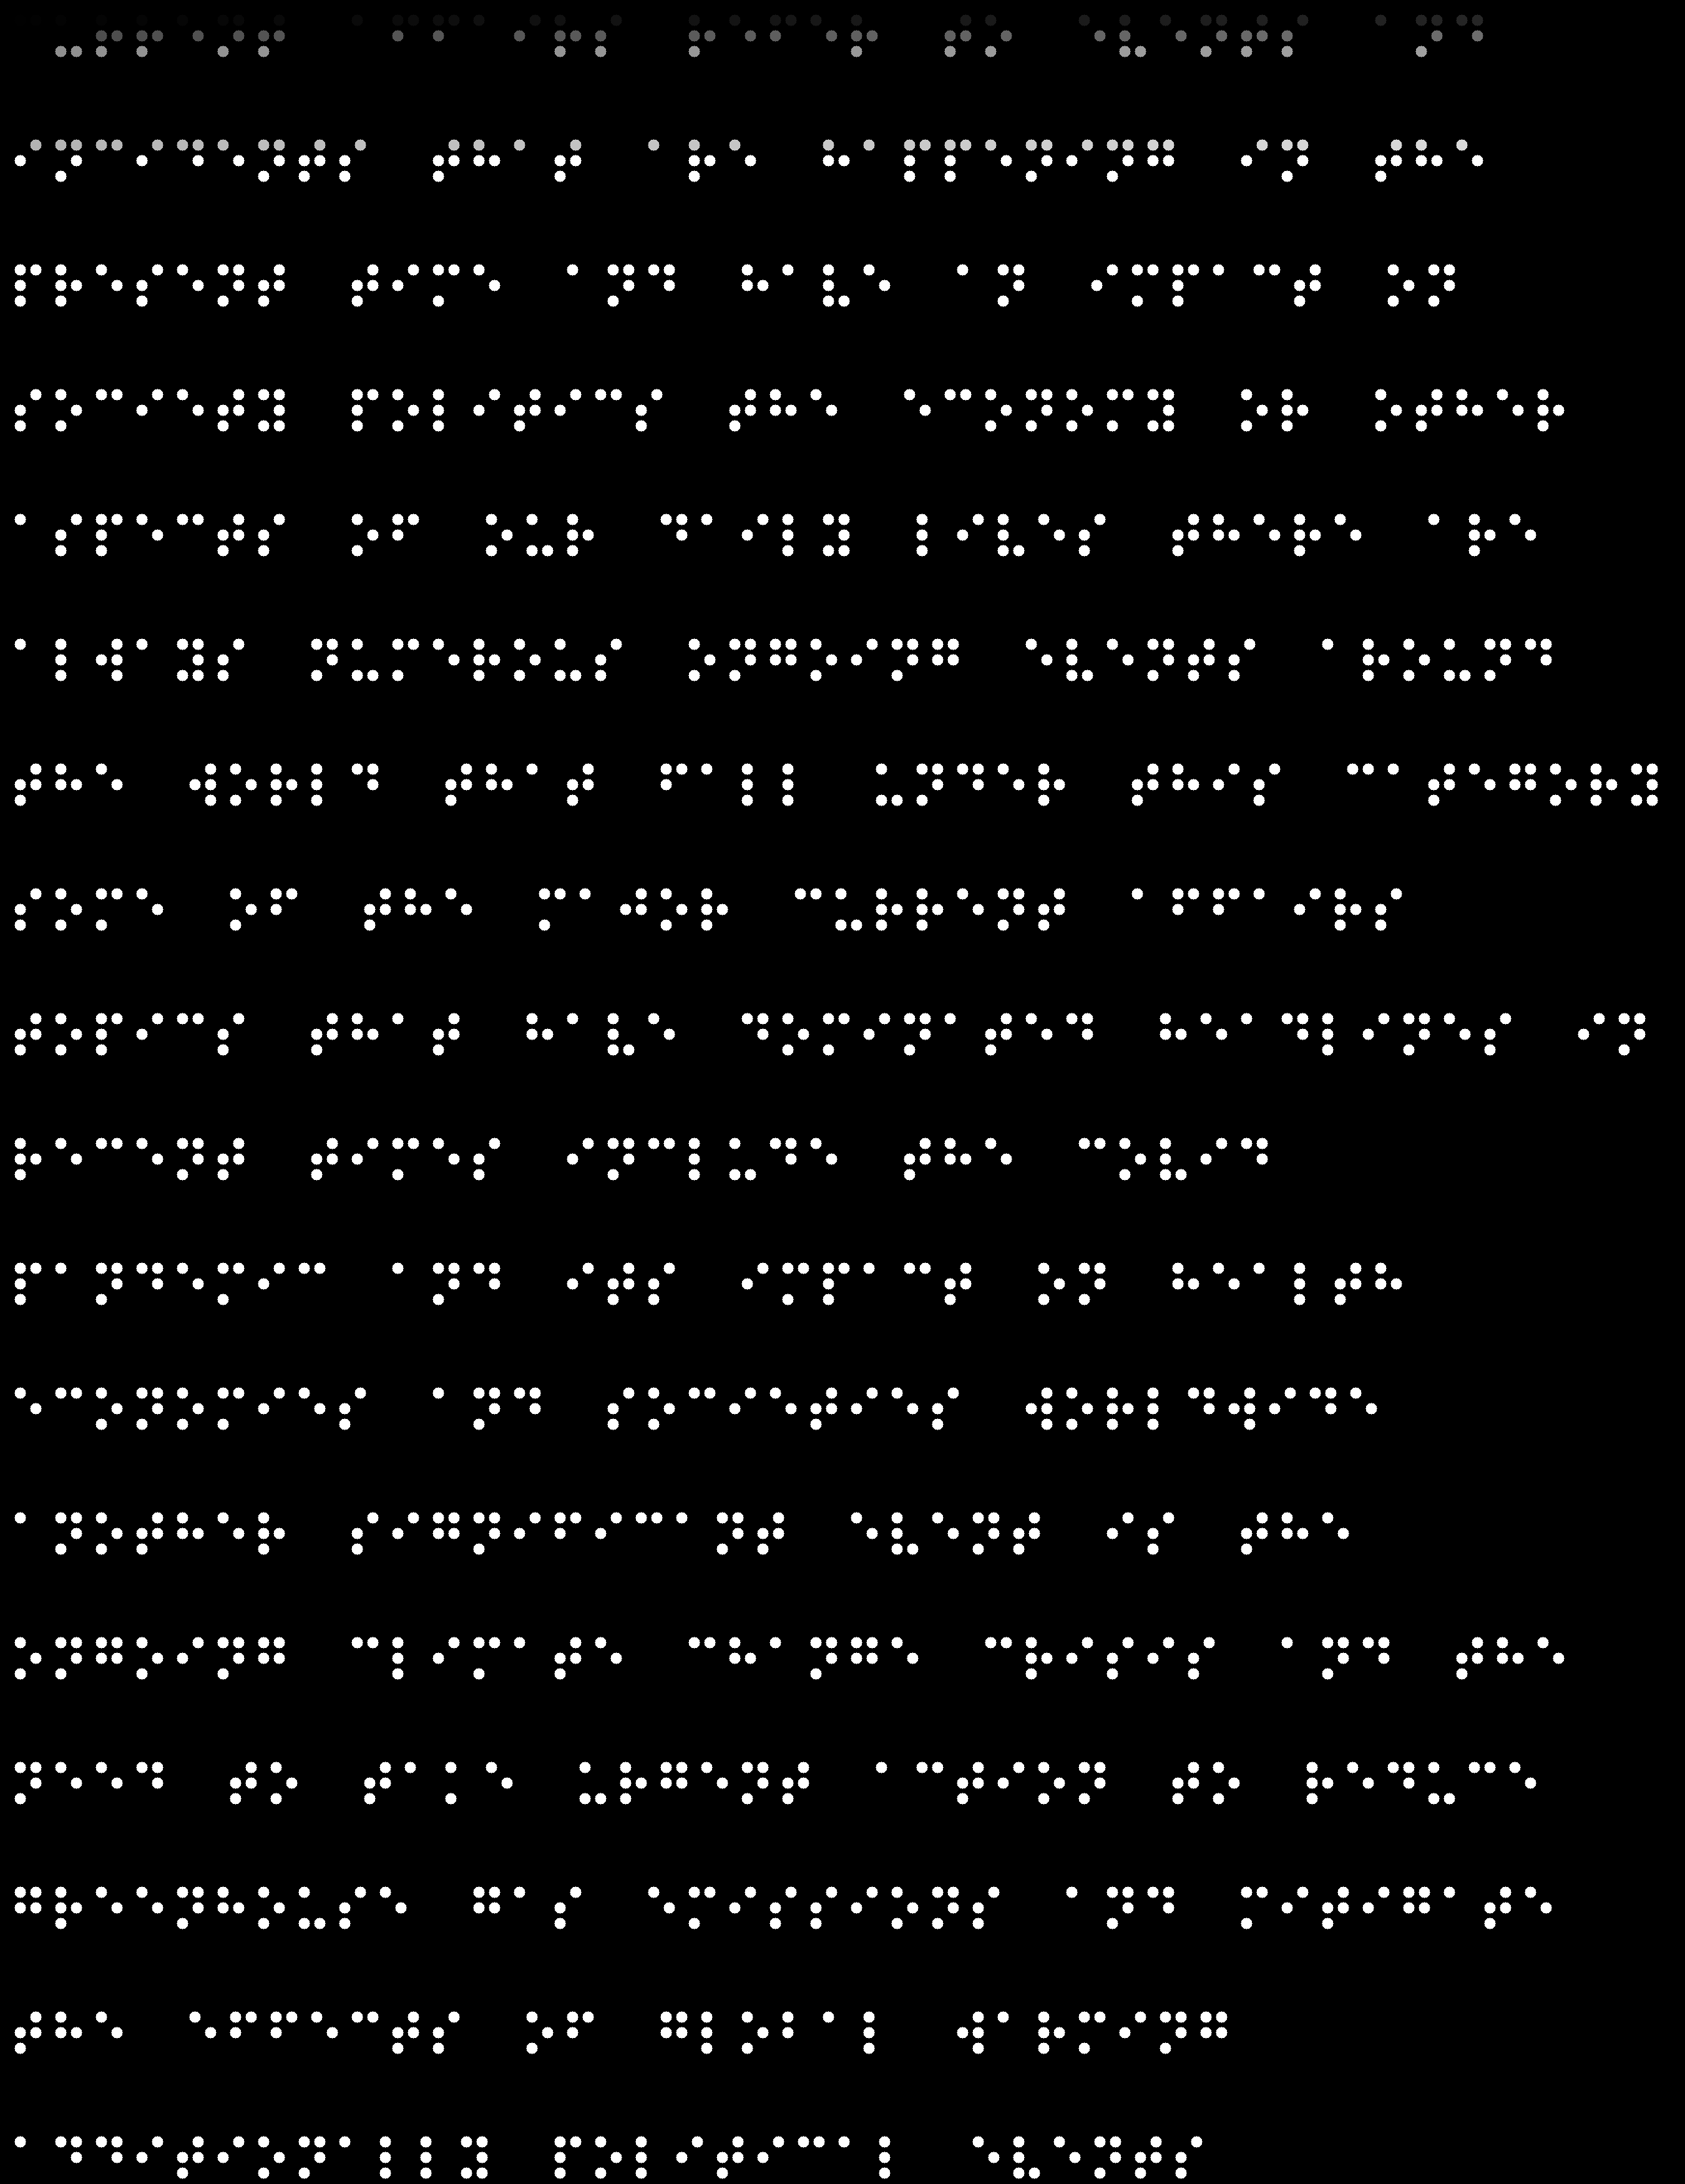

In [ ]:
# Viewing the resultant connected Matrix
cv2_imshow(connected_matrix)

In [ ]:
# Number of Objects Found
label

1553

#### Down-Scaling the Resultant-Image
* Find the center points of each Object Found in the Image
* Store the Resultant Center points as `1` in a new matrix, with all other intenisty value of the same object as `0`
* Push the `(X-Cord, Y-Cord)` Values for each object into Stack and find Pair-wise distance between objects.
* Find the minimum Distance between objects and use it as the threshold factor by which image is `Down-Scaled`
* Remove the Rows and Columns with all Zeros 

`Few Analysis and Visualization of this Concept is also show Below`


In [ ]:
# Find centroids of each connected component
centroids = []
for i in range(1, label+1):
    # Calculate moments of the connected component
    moments = cv2.moments(np.uint8(connected_matrix == i), binaryImage=True)

    centroids.append(moments)

# Convert the centroids list to a numpy array
centroids = np.array(centroids)

# Create a new binary matrix to represent the location of centroids
centroid_matrix = np.zeros_like(thresh, dtype=int)

# Place centroids on new matrix
for i, centroid in enumerate(centroids):
    
    if centroid["m00"] != 0:
        centroid_x = int(centroid["m10"] / centroid["m00"])
        centroid_y = int(centroid["m01"] / centroid["m00"])

        # Set the corresponding element in the centroid matrix to 1
        centroid_matrix[centroid_y, centroid_x] = 1

In [ ]:
# Calculate the distances between centroids
y_coords, x_coords = np.where(centroid_matrix == 1)
coords = np.column_stack((y_coords, x_coords))
distances = np.sqrt(np.sum((coords[:, np.newaxis, :] - coords) ** 2, axis=2))

# Find the smallest non-zero distance
min_distance = np.min(distances[np.nonzero(distances)])

# Calculate the threshold distance to reduce the matrix size
threshold_distance = min_distance 

# Create a new binary matrix with smaller size based on the threshold distance
new_shape = (int(thresh.shape[0] / threshold_distance), int(thresh.shape[1] / threshold_distance))
new_centroid_matrix = np.zeros(new_shape, dtype=int)

for centroid in centroids:
    
    if centroid["m00"] != 0:
        centroid_x = int(centroid["m10"] / centroid["m00"])
        centroid_y = int(centroid["m01"] / centroid["m00"])

        new_centroid_x = int(np.ceil(centroid_x / threshold_distance))
        new_centroid_y = int(np.ceil(centroid_y / threshold_distance))

        # Set the corresponding element in the new centroid matrix to 1
        new_centroid_matrix[new_centroid_y, new_centroid_x] = 1


In [ ]:
# Down-Scaled Matrix Shape
new_centroid_matrix.shape

(140, 108)

In [ ]:
# Analyzing Matrix to see if downscaling the image was success
new_centroid_matrix[1, 0:20], new_centroid_matrix[2, 0:20], new_centroid_matrix[3, 0:20], new_centroid_matrix[4, 0:20], new_centroid_matrix[5, 0:20], new_centroid_matrix[6, 0:20], new_centroid_matrix[7, 0:20], new_centroid_matrix[8, 0:20], new_centroid_matrix[9, 0:20], new_centroid_matrix[10, 0:20], new_centroid_matrix[11, 0:20], new_centroid_matrix[12, 0:20], new_centroid_matrix[13, 0:20], new_centroid_matrix[14, 0:20], new_centroid_matrix[15, 0:20], new_centroid_matrix[16, 0:20], new_centroid_matrix[17, 0:20], new_centroid_matrix[18, 0:20], new_centroid_matrix[19, 0:20], new_centroid_matrix[20, 0:20], new_centroid_matrix[21, 0:20], new_centroid_matrix[22, 0:20], new_centroid_matrix[23, 0:20], new_centroid_matrix[24, 0:20], new_centroid_matrix[25, 0:20], new_centroid_matrix[26, 0:20], new_centroid_matrix[27, 0:20], new_centroid_matrix[28, 0:20], new_centroid_matrix[29, 0:20], new_centroid_matrix[30, 0:20]

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0]),
 array([0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0]),
 array([0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0]),
 array([0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0]),
 array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([0, 0, 0, 0, 

In [ ]:
# Eliminating Non-zero rows and columns
zero_rows = np.all(new_centroid_matrix == 0, axis =1)
zero_cols = np.all(new_centroid_matrix == 0, axis =0)

newest_centroid_matrix = new_centroid_matrix[~zero_rows][:, ~zero_cols]
newest_centroid_matrix

array([[1, 1, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       ...,
       [1, 0, 1, ..., 0, 0, 0],
       [0, 1, 1, ..., 0, 1, 1],
       [1, 1, 0, ..., 0, 0, 0]])

In [ ]:
# Final Down-scaled matrix that present each dot as 1 
newest_centroid_matrix[0, 0:20], newest_centroid_matrix[1, 0:20], newest_centroid_matrix[2, 0:20], newest_centroid_matrix[3, 0:20], newest_centroid_matrix[4, 0:20], newest_centroid_matrix[5, 0:20], newest_centroid_matrix[7, 0:20], newest_centroid_matrix[8, 0:20], newest_centroid_matrix[9, 0:20], newest_centroid_matrix[10, 0:20], newest_centroid_matrix[1, 15:35], newest_centroid_matrix[12, 0:20], newest_centroid_matrix[13, 0:20], newest_centroid_matrix[14, 0:20], newest_centroid_matrix[15, 0:20], newest_centroid_matrix[16, 0:20], newest_centroid_matrix[17, 0:20], newest_centroid_matrix[18, 0:20], newest_centroid_matrix[19, 0:20], newest_centroid_matrix[20, 0:20]

(array([1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1]),
 array([0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0]),
 array([0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0]),
 array([0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0]),
 array([1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1]),
 array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1]),
 array([1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1]),
 array([1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1]),
 array([0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1]),
 array([1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1]),
 array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0]),
 array([1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1]),
 array([0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0]),
 array([0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1]),
 array([1, 0, 1, 0, 

#### Decoding the Down-Scaled Matrix
* This code generalizes well
* All special cases while decoding are dealt within the code.

In [ ]:
# Define the Braille codes and their corresponding positions in the 3x2 filter
braille_codes = {"000000": " ", "100000": "A", "101000": "B", "110000": "C", "110100": "D",
                 "100100": "E", "111000": "F", "111100": "G", "101100": "H", "011000": "I",
                 "011100": "J", "100010": "K", "101010": "L", "110010": "M", "110110": "N",
                 "100110": "O", "111010": "P", "111110": "Q", "101110": "R", "011010": "S",
                 "011110": "T", "100011": "U", "101011": "V", "011101": "W", "110011": "X",
                 "110111": "Y", "100111": "Z"}

filter = np.zeros(6).reshape(3, 2).astype(int)

# row = 66, shape = 102
row, col = newest_centroid_matrix.shape
decoded_matrix = []

check_2 = False
increment =0

for i in range(0, row-2, 3):
    decoded_row = []
    increment = 0
    check_2 = False
    for j in range(0, col-1, 2):
     
      if check_2 == True:
        j += increment

      if newest_centroid_matrix[i:i+3, min(j, col-1)].sum() > 0:
        encoded_char = [
            str(newest_centroid_matrix[i][min(j, col-1)]), 
            str(newest_centroid_matrix[i][min(j+1, col-1)]), 
            str(newest_centroid_matrix[min(i+1, row-1)][min(j, col-1)]), 
            str(newest_centroid_matrix[min(i+1, row-1)][min(j+1, col-1)]), 
            str(newest_centroid_matrix[min(i+2, row-1)][min(j, col-1)]), 
            str(newest_centroid_matrix[min(i+2, row-1)][min(j+1, col-1)])
        ]
        encoded_str = ''.join(encoded_char)

        if encoded_str in braille_codes:
          decoded_row.append(braille_codes[encoded_str])

      elif (newest_centroid_matrix[i:i+3, min(j, col-1)].sum() == 0).all() and (newest_centroid_matrix[i:i+3, min(j+1, col-1)].sum() == 0).all():
        decoded_row.append(braille_codes["000000"])

      elif (newest_centroid_matrix[i:i+3, j] == 0).all() and newest_centroid_matrix[i:i+3, j+1].sum() > 0:
        encoded_char = [
            str(newest_centroid_matrix[i][min(j+1, col-1)]), 
            str(newest_centroid_matrix[i][min(j+2, col-1)]), 
            str(newest_centroid_matrix[min(i+1, row-1)][min(j+1, col-1)]), 
            str(newest_centroid_matrix[min(i+1, row-1)][min(j+2, col-1)]), 
            str(newest_centroid_matrix[min(i+2, row-1)][min(j+1, col-1)]), 
            str(newest_centroid_matrix[min(i+2, row-1)][min(j+2, col-1)])]

        encoded_str = ''.join(encoded_char)

        if encoded_str in braille_codes:
          decoded_row.append(braille_codes[encoded_str])

        check_2=True
        increment+=1

    decoded_matrix.append(decoded_row)

In [ ]:
# Output 
for i in range(len(decoded_matrix)):
  sentence = ''.join(decoded_matrix[i])
  print(sentence)

CURRENT  AFFAIRS  REFER  TO  EVENTS  AND           
INCIDENTS  THAT  ARE  HAPPENING  IN  THE           
PRESENT  TIME  AND  HAVE  AN  IMPACT  ON           
SOCIETY  POLITICS  THE  ECONOMY  OR  OTHER         
ASPECTS  OF  OUR  DAILY  LIVES  THERE  ARE         
ALWAYS  NUMEROUS  ONGOING  EVENTS  AROUND          
THE WORLD  THAT  FALL  UNDER  THIS  CATEGORY
SOME  OF  THE  MAJOR  CURRENT  AFFAIRS             


#### Error Encountered and Analysis
* Error: Only half of the Image was Decoded.
* Apparently Decoding the Down-Scale Matrix Generalizes well

`Where Does the Issue lies?`
* After thorough Debugging, the issue was found that many objects didn't had thier neighbouring intensities equal to 0, which was the cause of these objects not listing out in the output Down-Scale Matrix as I found Objects Center points through `cv2.moments()`
* I even used a Friends 8-CCA function to make sure error was not in 8-CCA function and the results were same.

` Error Visualization is also Shown below`

In [ ]:
# marking the objects with neighbouring intensities (mass of object) > 0 with red cross
for i in range(len(x_coords)):
    x = x_coords[i]
    y = y_coords[i]
    img_with_centroid = cv2.drawMarker(image_matrix, (x, y), color=(0, 0, 255), markerType=cv2.MARKER_CROSS, thickness=8)


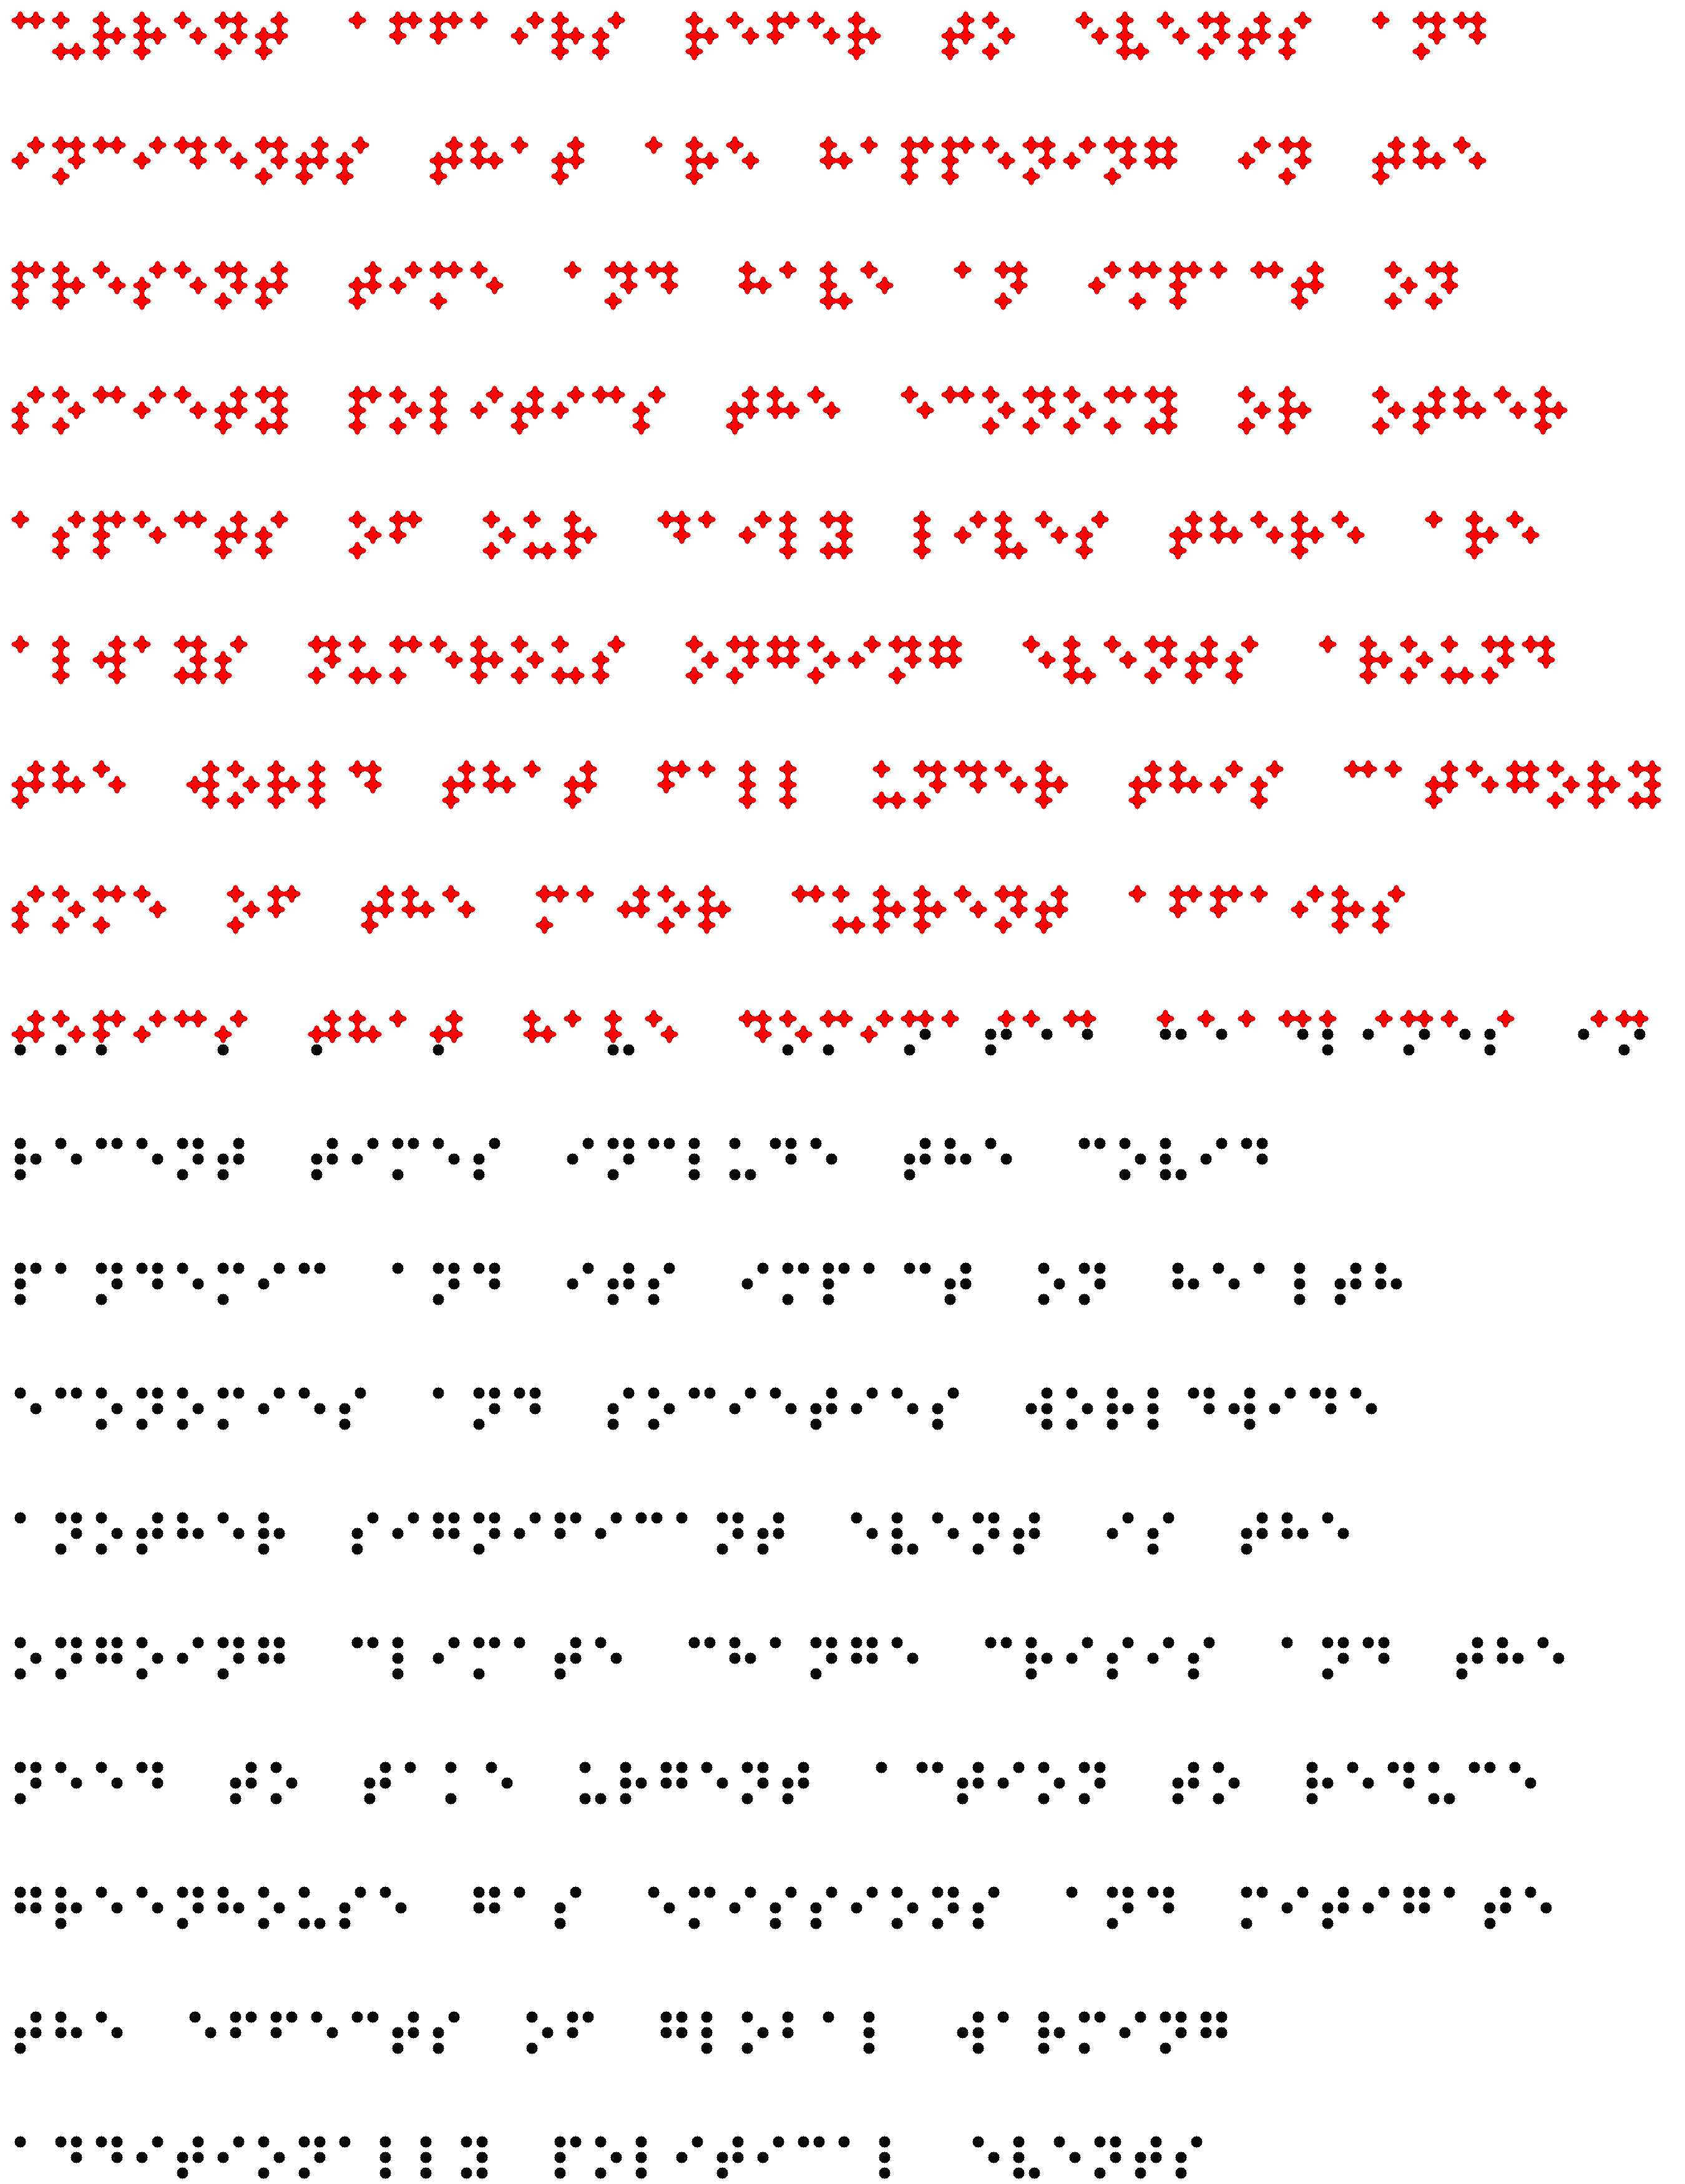

In [ ]:
# results
cv2_imshow(img_with_centroid)

In [ ]:
# Number of objects that had mass = 0
index = 0
for my_dict in centroids:
    if my_dict['m00'] == 0:
        index +=1

index

767

In [ ]:
# Number of objects who had mass > 1 and their centroids were found
len(y_coords), len(x_coords)

(786, 786)

* I did regenrated the same brialle code from:    `url: https://lingojam.com/BrailleTranslator`


* Generated Brialle code could not fit into one snippet, so rather I took the snippet of just last part of generate brialle code to show the results.
* Following are the results of Brialle-code Used, The Number of Objects found in the brialle code and its Output:



##### Brialle Code Used:

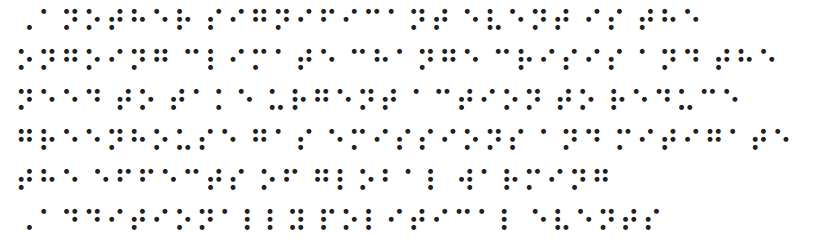

##### Number of Objects found in the brialle code:

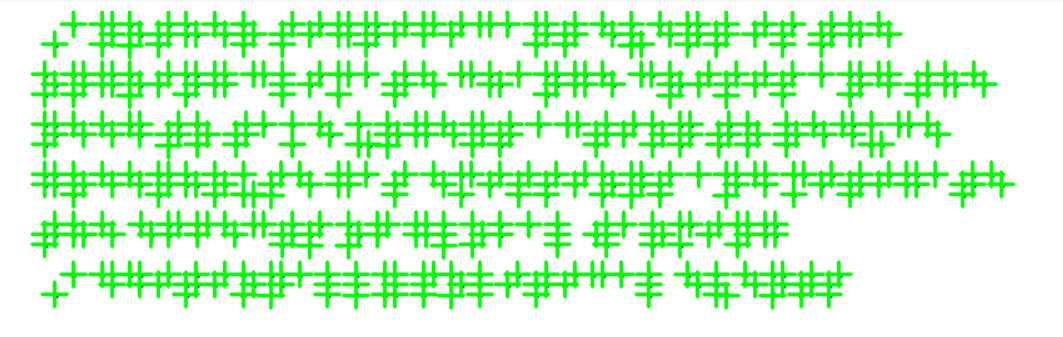

##### Brialle Code Decoded Output:

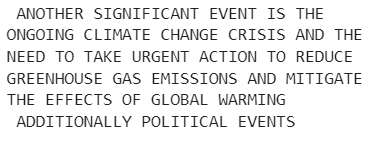